# Automating the Cybersecurity Triage Process: A Comparative Study on the Performance of Large Language Models

Install required libraries, including OpenAI and Ollama

In [ ]:
!pip install openai
!pip install ollama
!pip install pandas
!pip install openpyxl
!pip install matplotlib

Import libraries

In [163]:
import os
import time
import json
import pandas as pd
import matplotlib.pyplot as plt
from statistics import median
from abc import abstractmethod, ABC
from typing import Any
from openai import AzureOpenAI
from ollama import Client

plt.style.use('tableau-colorblind10')

Define Abstraction Class for Language Models and Prompts.

In [3]:
class Prompt:

    def __init__(self, system: str, user: str):
        self.system = system
        self.user = user


class LanguageModel:

    def __init__(self, model_id: str):
        self.model_id = model_id

    @abstractmethod
    def generate(self, prompt: Prompt) -> dict[str, str]:
        pass


class PromptGenerator:

    @abstractmethod
    def generate(self, input_value: any) -> Prompt:
        pass

    @abstractmethod
    def get_id(self) -> str:
        pass

    @abstractmethod
    def get_field(self) -> str:
        pass


class JsonPromptGenerator(PromptGenerator, ABC):

    def __init__(self, data: dict[str, str]):
        self.data = data

    def get_field(self) -> str:
        return self.data['field']

    def get_id(self) -> str:
        return self.data['id']


def load_json(path: str) -> dict[str, Any]:
    with open(path, 'r') as f:
        return json.load(f)

Implement OpenAI Language Model.

**Note:** This requires environment variables to be set.

In [4]:
OPENAI_KEY: str = os.getenv("OPENAI_KEY")  # API key
OPENAI_ENDPOINT: str = os.getenv("OPENAI_ENDPOINT")  # Host URL
OPENAI_DEPLOYMENT: str = os.getenv("OPENAI_DEPLOYMENT")  # Model ID


class OpenAILanguageModel(LanguageModel):
    client = AzureOpenAI(azure_endpoint=OPENAI_ENDPOINT, api_key=OPENAI_KEY, api_version="2024-02-15-preview")

    def generate(self, prompt: Prompt) -> dict[str, str]:
        try:
            t0 = time.time()
            response = OpenAILanguageModel.client.chat.completions.create(
                model=self.model_id,
                messages=[
                    {"role": "system", "content": prompt.system},
                    {"role": "user", "content": prompt.user},
                ],
                response_format={"type": "json_object"}
            )
            t1 = time.time()

            return {'response': response.choices[0].message.content,
                    'in_tokens': response.usage.prompt_tokens,
                    'out_tokens': response.usage.completion_tokens,
                    'time': t1 - t0}

        except Exception as e:
            return {'error': str(e)}

Implement Ollama Language Model.

**Note:** This requires Ollama to be running in the background on the address equal to `OLLAMA_HOST`.
This is done by executing `ollama serve`.

In [5]:
OLLAMA_HOST = 'http://localhost:11434'


class OllamaLanguageModel(LanguageModel):
    client = Client(host=OLLAMA_HOST)

    def generate(self, prompt: Prompt) -> dict[str, str]:
        try:
            t0 = time.time()
            result = OllamaLanguageModel.client \
                .generate(model=self.model_id,
                          system=prompt.system,
                          prompt=prompt.user,
                          format='json',
                          stream=False)
            # consider bug where repeated token limit is reached and output is aborted but not marked as done
            if result['done']:
                result['time'] = result['total_duration'] / 1e9
            else:
                result['time'] = time.time() - t0
            return result

        except Exception as e:
            return {'error': str(e)}

Create model clients.

**Note:** This script assumes that the Ollama models have already been pulled.

In [158]:
models: dict[str, LanguageModel] = {
    'llama3': OllamaLanguageModel('llama3:8b'),  # 8b
    'phi3': OllamaLanguageModel('phi3:14b'),  # 14b
    'phi3-mini': OllamaLanguageModel('phi3:3.8b'),  # 3.8b
    'aya23': OllamaLanguageModel('aya:8b'),  # 8b
    'mistral': OllamaLanguageModel('mistral:7b'),  # 7b
    'codellama': OllamaLanguageModel('codellama:13b'),  # 7b
    'gemma': OllamaLanguageModel('gemma:7b'),  # 7b
    'gemma-mini': OllamaLanguageModel('gemma:2b'),  # 2b
    'gpt4': OpenAILanguageModel(OPENAI_DEPLOYMENT),  # 1760b
}

model_names = {k: m.model_id for k, m in models.items()}
model_names['gpt4'] = 'GPT-4'

Setup evaluation framework

In [182]:
def parse_model_response(response: str, field: str) -> bool | None:
    """
    Parse the JSON output of a language model and return True or False depending on the answer.
    Incorrect JSON syntax will return False.
    :param response: The JSON output of a language model.
    :param field: The JSON key that contains the boolean value.
    :return: True or False.
    """
    try:
        return json.loads(response)[field]
    except (TypeError, KeyError) as _:
        return None


def execute_all_on_model(model: LanguageModel, prompts: list[Prompt], delay: int = 0) -> list[dict[str, str]]:
    result = []
    first_run = True
    for prompt in prompts:
        if not first_run:
            time.sleep(delay)
        result.append(model.generate(prompt))  # execute prompt
        first_run = False
    return result


def generate_prompts(prompt_generator: PromptGenerator, input_values: list[str]) -> list[Prompt]:
    return [prompt_generator.generate(value) for value in input_values]


def evaluate_model_outputs(predicted: list[bool], actual: list[bool]) -> dict[str, bool]:
    tp, tn, fp, fn = 0, 0, 0, 0
    for _p, _a in zip(predicted, actual):
        if _p and _a:
            tp += 1
        elif _p and not _a:
            fp += 1
        elif not _p and _a:
            fn += 1
        elif not _p and not _a:
            tn += 1
    return {'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn}


def get_evaluation_statistics(tp: int, tn: int, fp: int, fn: int) -> dict[str, float]:
    accuracy = 0.0 if sum((tp, tn, fp, fn)) == 0 else (tp + tn) / (tp + tn + fp + fn)
    precision = 0.0 if tp == 0 else tp / (tp + fp)
    recall = 0.0 if tp == 0 else tp / (tp + fn)
    f1 = 0.0 if tp == 0 else 2 * precision * recall / (precision + recall)
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }


def get_model_responses(outputs: list[dict[str, str]]) -> list[str]:
    return [output['response'] for output in outputs if 'response' in output]


def evaluate(model: LanguageModel,
             prompts: list[Prompt],
             classifications: list[bool],
             field: str,
             delay: int = 0) -> dict[str, float]:
    outputs: list[dict[str, str]] = execute_all_on_model(model, prompts, delay)
    median_time = median(o['time'] for o in outputs if 'time' in o)
    responses = get_model_responses(outputs)
    for response in responses:
        print(response)
    parsed_raw = [parse_model_response(response, field) for response in responses]
    errors = len([p for p in parsed_raw if p is None])
    parsed = [p for p in parsed_raw if p is not None]
    evaluation = evaluate_model_outputs(parsed, classifications)
    statistics = get_evaluation_statistics(**evaluation)
    statistics['time'] = median_time
    statistics['errors'] = errors
    return statistics | evaluation  # join dicts


def evaluate_all(language_models: dict[str, LanguageModel],
                 prompt_generators: dict[str, PromptGenerator],
                 dataset: tuple[list[str], list[bool]],
                 delay: int = 0) -> dict[str, dict[str, dict[str, float]]]:
    prompts_dict: dict[str, list[Prompt]] = {
        key: generate_prompts(generator, dataset[0])
        for key, generator in prompt_generators.items()
    }

    nested: dict[str, dict[str, dict[str, float]]] = dict()

    for model_id, model in language_models.items():
        print(model_id)
        model_result = dict()
        nested[model_id] = model_result
        first_run = True
        for prompt_id, prompts in prompts_dict.items():
            print('\t' + prompt_id)
            if not first_run:  # wait between prompt runs
                time.sleep(delay)
            evaluation = evaluate(model, prompts, dataset[1], prompt_generators[prompt_id].get_field())
            print('\t\t' + str(evaluation))
            model_result[prompt_id] = evaluation
            first_run = False

    return nested


def transform_evaluation(nested: dict[str, dict[str, dict[str, float]]]) -> pd.DataFrame:
    df = pd.DataFrame.from_dict(nested, orient='index').stack().to_frame()
    return pd.DataFrame(df[0].values.tolist(), index=df.index)


## Detect Email Announcements



In [132]:
class DetectAnnouncementPrompt(JsonPromptGenerator):

    def generate(self, email: str) -> Prompt:
        return Prompt(self.data['system'], self.data['user'] + '\n' + email)


detect_email_announcement_prompts: dict[str, PromptGenerator] = {
    key: DetectAnnouncementPrompt(value)
    for key, value in load_json('data/detect_announcement_prompts.json').items()
}

Get announcement email dataset.

In [9]:
announcement_emails = pd.read_excel('data/announcement_emails.xlsx') \
    .rename(columns={'cleaned_email_body': 'email'})[['email']]
announcement_emails['is_announcement'] = True
announcement_emails

,email,is_announcement
0,name13 will be working on AZWEU-OLSTB01 today....,True
1,We will add the user name15 as a owner to the ...,True
2,name16 will use his admin account (Ka6053adm) ...,True
3,We did some testing on the SRV602 with discove...,True
4,name1 applied the scheduled task to the SVR-ND...,True
5,name2 just created an external mail forwarding...,True
6,name3 be loggin in on the VM-DCS-01 with my Ex...,True
7,customer3 announced that the user 'jedox-power...,True
8,name4 will add the user Jayy.Watson01 to the b...,True
9,customer5 will add the user “sea_line” to the ...,True


Get normal emails from Enron dataset.

In [127]:
normal_emails = pd.read_csv('data/enron.csv', nrows=500) \
    .rename(columns={'Message': 'email'})[['email']]
normal_emails_sizes = normal_emails['email'].map(len)  # get email sizes
normal_emails = (normal_emails[(normal_emails_sizes > 100) & (normal_emails_sizes < 500)]
                 .where(lambda x: ~x['email'].str.startswith('-' * 10))  # filter forwards
                 .dropna()
                 .sample(20))  # filter by email size and select 20
normal_emails['is_announcement'] = False
normal_emails

,email,is_announcement
17,"Tim,\n\nmike grigsby is having problems with a...",False
303,Are there behind closed doors discussions bein...,False
178,"Mary,\n\nIf we add both balances together the ...",False
291,Have him send his resume to Karen Buckley in H...,False
379,I also need to know the base salaries of Jay R...,False
497,"Nick,\n\nThere is a specific program that we a...",False
404,"Al,\n\nI was not going to do the MS this year....",False
363,How am I to send them the money for the silent...,False
230,Anymore details? Is the offer above or below ...,False
447,"Lucy,\n\nThanks for clearing up the 2/2 file. ...",False


Concatenate the announcement and non-announcement datasets.

In [128]:
emails = pd.concat([announcement_emails, normal_emails]).sample(frac=1).reset_index(drop=True)
emails

,email,is_announcement
0,"Lucy,\n\nWhat is the latest? Write me a note ...",False
1,"Lucy,\n\nThanks for clearing up the 2/2 file. ...",False
2,name3 be loggin in on the VM-DCS-01 with my Ex...,True
3,We will add the user name15 as a owner to the ...,True
4,name2 just created an external mail forwarding...,True
5,"Mr. Buckner,\n\n For delivered gas behind San ...",False
6,"Jim,\n\nIs there going to be a conference call...",False
7,"Hi,\n\nFYI iam changing some membership in hig...",True
8,I also need to know the base salaries of Jay R...,False
9,customer5 will add the user “sea_line” to the ...,True


Split into dataset for prediction and actual classification.

In [253]:
email_bodies: list[str] = [*emails['email'].values]
is_actual_announcement: list[bool] = [*emails['is_announcement'].values]
detect_announcement_dataset = (email_bodies, is_actual_announcement)
detect_announcement_dataset_size = len(emails)

Run all prompts on all models.

In [134]:
announcement_detection_evaluation_dict = evaluate_all(
    {i: models[i] for i in models if i != 'gpt4'},
    detect_email_announcement_prompts,
    detect_announcement_dataset
)

llama3
	long
		{'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'time': 0.65557165, 'errors': 0, 'tp': 20, 'tn': 20, 'fp': 0, 'fn': 0}
	medium
		{'accuracy': 0.9, 'precision': 0.9, 'recall': 0.9, 'f1': 0.9, 'time': 0.6186087499999999, 'errors': 0, 'tp': 18, 'tn': 18, 'fp': 2, 'fn': 2}
	short
		{'accuracy': 0.825, 'precision': 0.782608695652174, 'recall': 0.9, 'f1': 0.8372093023255814, 'time': 0.62294995, 'errors': 0, 'tp': 18, 'tn': 15, 'fp': 5, 'fn': 2}
phi3
	long
		{'accuracy': 0.8461538461538461, 'precision': 0.8421052631578947, 'recall': 0.8421052631578947, 'f1': 0.8421052631578947, 'time': 3.94631295, 'errors': 1, 'tp': 16, 'tn': 17, 'fp': 3, 'fn': 3}
	medium
		{'accuracy': 0.5, 'precision': 0.4666666666666667, 'recall': 0.4375, 'f1': 0.45161290322580644, 'time': 2.9515961, 'errors': 6, 'tp': 7, 'tn': 10, 'fp': 8, 'fn': 9}
	short
		{'accuracy': 0.6, 'precision': 0.6, 'recall': 0.6, 'f1': 0.6, 'time': 2.9741349, 'errors': 30, 'tp': 3, 'tn': 3, 'fp': 2, 'fn': 2}
phi3-mi

In [138]:
announcement_detection_evaluation_dict_gpt4 = evaluate_all(
    {'gpt4': models['gpt4']},
    detect_email_announcement_prompts,
    detect_announcement_dataset,
    7  # seconds delay between prompts to prevent timeout or token limit
)

gpt4
	long
		{'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'time': 8.456403374671936, 'errors': 0, 'tp': 20, 'tn': 20, 'fp': 0, 'fn': 0}
	medium
		{'accuracy': 0.95, 'precision': 0.95, 'recall': 0.95, 'f1': 0.9500000000000001, 'time': 7.540701627731323, 'errors': 0, 'tp': 19, 'tn': 19, 'fp': 1, 'fn': 1}
	short
		{'accuracy': 0.725, 'precision': 1.0, 'recall': 0.45, 'f1': 0.6206896551724138, 'time': 10.939746737480164, 'errors': 0, 'tp': 9, 'tn': 20, 'fp': 0, 'fn': 11}


Transform output into dataframe.

In [246]:
announcement_detection_evaluation = transform_evaluation(
    announcement_detection_evaluation_dict | announcement_detection_evaluation_dict_gpt4
)
# announcement_detection_evaluation = transform_evaluation(announcement_detection_evaluation_dict)
announcement_detection_evaluation.index = announcement_detection_evaluation.index.rename(['Model', 'Prompt'])
announcement_detection_evaluation = announcement_detection_evaluation.rename(index=model_names)
announcement_detection_evaluation

accuracy  precision    recall        f1       time  \
Model         Prompt                                                       
llama3:8b     long    1.000000   1.000000  1.000000  1.000000   0.655572   
              medium  0.900000   0.900000  0.900000  0.900000   0.618609   
              short   0.825000   0.782609  0.900000  0.837209   0.622950   
phi3:14b      long    0.846154   0.842105  0.842105  0.842105   3.946313   
              medium  0.500000   0.466667  0.437500  0.451613   2.951596   
              short   0.600000   0.600000  0.600000  0.600000   2.974135   
phi3:3.8b     long    1.000000   1.000000  1.000000  1.000000   0.354911   
              medium  0.925000   0.904762  0.950000  0.926829   0.375451   
              short   0.750000   0.857143  0.600000  0.705882   0.875344   
aya:8b        long    0.825000   0.760000  0.950000  0.844444   1.512630   
              medium  0.775000   0.703704  0.950000  0.808511   1.420947   
              short   0.625000   0.727273  0.400000  0.516129   1.394327   
mistral:7b    long    1.000000   1.000000  1.000000  1.000000   0.487178   
              medium  0.900000   0.944444  0.850000  0.894737   0.411070   
              short   0.775000   0.866667  0.650000  0.742857   0.404801   
codellama:13b long    1.000000   1.000000  1.000000  1.000000   3.426116   
              medium  0.750000   0.857143  0.600000  0.705882   3.388549   
              short   0.600000   0.642857  0.450000  0.529412   3.315432   
gemma:7b      long    0.775000   1.000000  0.550000  0.709677   1.787137   
              medium  0.775000   1.000000  0.550000  0.709677   1.686560   
              short   0.700000   0.722222  0.650000  0.684211   1.679959   
gemma:2b      long    0.825000   1.000000  0.650000  0.787879   0.193562   
              medium  0.600000   1.000000  0.200000  0.333333   0.192012   
              short   0.575000   0.548387  0.850000  0.666667   0.192428   
GPT-4         long    1.000000   1.000000  1.000000  1.000000   8.456403   
              medium  0.950000   0.950000  0.950000  0.950000   7.540702   
              short   0.725000   1.000000  0.450000  0.620690  10.939747   

                      errors  tp  tn  fp  fn  
Model         Prompt                          
llama3:8b     long         0  20  20   0   0  
              medium       0  18  18   2   2  
              short        0  18  15   5   2  
phi3:14b      long         1  16  17   3   3  
              medium       6   7  10   8   9  
              short       30   3   3   2   2  
phi3:3.8b     long         0  20  20   0   0  
              medium       0  19  18   2   1  
              short        0  12  18   2   8  
aya:8b        long         0  19  14   6   1  
              medium       0  19  12   8   1  
              short        0   8  17   3  12  
mistral:7b    long         0  20  20   0   0  
              medium       0  17  19   1   3  
              short        0  13  18   2   7  
codellama:13b long         0  20  20   0   0  
              medium       0  12  18   2   8  
              short        0   9  15   5  11  
gemma:7b      long         0  11  20   0   9  
              medium       0  11  20   0   9  
              short        0  13  15   5   7  
gemma:2b      long         0  13  20   0   7  
              medium       0   4  20   0  16  
              short        0  17   6  14   3  
GPT-4         long         0  20  20   0   0  
              medium       0  19  19   1   1  
              short        0   9  20   0  11

Export the important metrics as a Latex table.

In [254]:
df = announcement_detection_evaluation[['f1','time']].copy()
df['error_rate'] = announcement_detection_evaluation['errors'] / detect_announcement_dataset_size
df.columns.name = 'Metric'
s = df.stack()
s.name = 'Value'
print(s.to_frame().reorder_levels(['Model','Metric','Prompt']).unstack(level=-1).unstack().to_latex(float_format='%.3f'))

\begin{tabular}{lrrrrrrrrr}
\toprule
 & \multicolumn{9}{r}{Value} \\
Prompt & \multicolumn{3}{r}{long} & \multicolumn{3}{r}{medium} & \multicolumn{3}{r}{short} \\
Metric & f1 & time & error_rate & f1 & time & error_rate & f1 & time & error_rate \\
Model &  &  &  &  &  &  &  &  &  \\
\midrule
GPT-4 & 1.000 & 8.456 & 0.000 & 0.950 & 7.541 & 0.000 & 0.621 & 10.940 & 0.000 \\
aya:8b & 0.844 & 1.513 & 0.000 & 0.809 & 1.421 & 0.000 & 0.516 & 1.394 & 0.000 \\
codellama:13b & 1.000 & 3.426 & 0.000 & 0.706 & 3.389 & 0.000 & 0.529 & 3.315 & 0.000 \\
gemma:2b & 0.788 & 0.194 & 0.000 & 0.333 & 0.192 & 0.000 & 0.667 & 0.192 & 0.000 \\
gemma:7b & 0.710 & 1.787 & 0.000 & 0.710 & 1.687 & 0.000 & 0.684 & 1.680 & 0.000 \\
llama3:8b & 1.000 & 0.656 & 0.000 & 0.900 & 0.619 & 0.000 & 0.837 & 0.623 & 0.000 \\
mistral:7b & 1.000 & 0.487 & 0.000 & 0.895 & 0.411 & 0.000 & 0.743 & 0.405 & 0.000 \\
phi3:14b & 0.842 & 3.946 & 0.025 & 0.452 & 2.952 & 0.150 & 0.600 & 2.974 & 0.750 \\
phi3:3.8b & 1.000 & 0.355 & 0.0

<Axes: title={'center': 'Announcement Detection Evaluation'}, xlabel='F1-score', ylabel='Model'>

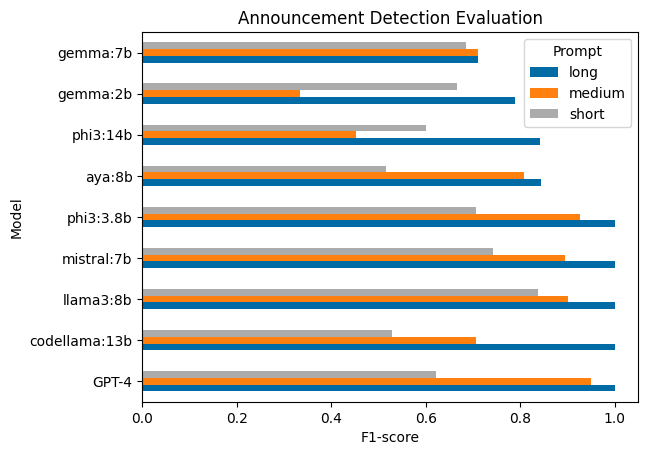

In [251]:
announcement_detection_f1 = announcement_detection_evaluation['f1']
ad_f1_axes = announcement_detection_f1.unstack() \
    .sort_values(by=next(iter(detect_email_announcement_prompts.keys())), ascending=False) \
    .plot(kind='barh', title='Announcement Detection Evaluation', xlabel='F1-score')
ad_f1_axes

In [165]:
ad_f1_axes.get_figure().savefig('data/announcement_detection_f1.pdf', format='pdf', bbox_inches='tight')

In [183]:
evaluate_all(
    {'phi3': models['phi3']},
    detect_email_announcement_prompts,
    detect_announcement_dataset
)

phi3
	long
{
    "is_announcement": false
}
{
    "is_announcement": false
}
{
  "is_announcement": false
}
{
    "is_announcement": true
}
{
    "is_announcement": true
}
{
    "is_announcement": false
}
{
    "is_announcement": false
}
{
  "is_announcement": true
}
{
  "is_announcement": false
}
{
    "is_announcement": true
}
{
    "is_announcement": false
}
{
  "is_announcement": true
}
{
    "is_announcement": false
}
{
  "is_announcement": true
}
{
    "is_announcement": false
}
{
    "is_announcement": true
}
{
    "is_announcement": true,
    "reasoning": "The email mentions granting access to manage financial products and refers to market-making activities in a specific cybersecurity context (one day gas daily swaps), which could potentially lead to changes or actions that create alarms or alerts."
}
{
  "is_announcement": true
}
{
    "is_announcement": false
}
{
  "is_announcement": false
}
{
  "is_announcement": false
}
{
    "is_announcement": true
}
{
  "is_announcement":

{'phi3': {'long': {'accuracy': 0.95,
   'precision': 0.95,
   'recall': 0.95,
   'f1': 0.9500000000000001,
   'time': 3.8578855,
   'errors': 0,
   'tp': 19,
   'tn': 19,
   'fp': 1,
   'fn': 1},
  'medium': {'accuracy': 0.5,
   'precision': 0.4666666666666667,
   'recall': 0.4375,
   'f1': 0.45161290322580644,
   'time': 2.977418,
   'errors': 6,
   'tp': 7,
   'tn': 10,
   'fp': 8,
   'fn': 9},
  'short': {'accuracy': 0.6,
   'precision': 0.6,
   'recall': 0.6,
   'f1': 0.6,
   'time': 2.91447605,
   'errors': 30,
   'tp': 3,
   'tn': 3,
   'fp': 2,
   'fn': 2}}}